In [1]:
# load libraries
%matplotlib inline
from utils import *
from time import time
from six.moves import cPickle as pickle
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import keras.callbacks as kcb

Using cuDNN version 5110 on context None
Preallocating 10867/11439 Mb (0.950000) on cuda
Mapped name None to device cuda: Tesla K80 (0000:00:1E.0)
Using Theano backend.


In [2]:
path = '/input/'
model_path = 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [3]:
%%bash
ls /input/

labeledTrainData.tsv
testData.tsv
test_labels.csv
unlabeledTrainData.tsv


In [12]:
train = pd.read_pickle(path+'train.pickle')
test = pd.read_pickle(path+'test.pickle')
ul_train = pd.read_pickle(path+'ul_train.pickle')

In [4]:
# import data
ul_train = pd.read_csv(path+'unlabeledTrainData.tsv', sep='\t', header=0, quoting=3)
train = pd.read_csv(path+'labeledTrainData.tsv', sep='\t')
test = pd.read_csv(path+'testData.tsv', sep='\t')

In [5]:
ul_train.shape, train.shape, test.shape

((50000, 2), (25000, 3), (25000, 2))

In [6]:
from sys import getsizeof
getsizeof(ul_train)/float(2**20), getsizeof(train)/float(2**20), getsizeof(test)/float(2**20)

(68.3608865737915, 34.14770317077637, 33.21155548095703)

In [7]:
# see the content in 'train'
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 3 columns):
id           25000 non-null object
sentiment    25000 non-null int64
review       25000 non-null object
dtypes: int64(1), object(2)
memory usage: 586.0+ KB


In [5]:
vocab_size = 50000
tokenizer = Tokenizer(nb_words=vocab_size)
tokenizer.fit_on_texts(train['review'])
trn_feature = tokenizer.texts_to_sequences(train['review'])
tt_feature = tokenizer.texts_to_sequences(test['review'])
ul_trn_feature = tokenizer.texts_to_sequences(ul_train['review'])

In [6]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(
    trn_feature, train['sentiment'], test_size=0.15, random_state=35)

seq_len = 500
train_x = sequence.pad_sequences(train_x, maxlen=seq_len, value=0)
val_x = sequence.pad_sequences(val_x, maxlen=seq_len, value=0)

In [7]:
test_x = sequence.pad_sequences(tt_feature, maxlen=seq_len, value=0)
test_y = pd.read_csv(path+'test_labels.csv')['sentiment'].values

In [47]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(
    trn_feature, train['sentiment'], test_size=0.15, random_state=35)

seq_len = 500
train_x = sequence.pad_sequences(train_x, maxlen=seq_len, value=0)
val_x = sequence.pad_sequences(val_x, maxlen=seq_len, value=0)

In [23]:
# callback function during training
class CallMetric(kcb.Callback):
    def on_train_begin(self, logs={}):
        self.accs = []
        self.val_accs = []
        self.losses = []
        self.val_losses = []
    def on_epoch_end(self, batch, logs={}):
        self.accs.append(logs.get('acc'))
        self.val_accs.append(logs.get('val_acc'))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

### FastText

In [49]:
from keras.layers import GlobalAveragePooling1D

In [71]:
fast = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, dropout=0.35),
    GlobalAveragePooling1D(),
    Dense(1, activation='sigmoid')])
fast.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [72]:
fast.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=64, nb_epoch=12)

Train on 21250 samples, validate on 3750 samples
Epoch 1/12
21250/21250 [==============================] - 1s - loss: 0.6724 - acc: 0.6569 - val_loss: 0.6293 - val_acc: 0.7893
Epoch 2/12
21250/21250 [==============================] - ETA: 0s - loss: 0.5761 - acc: 0.782 - 1s - loss: 0.5752 - acc: 0.7818 - val_loss: 0.5127 - val_acc: 0.8424
Epoch 3/12
21250/21250 [==============================] - 1s - loss: 0.4760 - acc: 0.8291 - val_loss: 0.4277 - val_acc: 0.8765
Epoch 4/12
21250/21250 [==============================] - 1s - loss: 0.4059 - acc: 0.8544 - val_loss: 0.3731 - val_acc: 0.8867
Epoch 5/12
21250/21250 [==============================] - 1s - loss: 0.3547 - acc: 0.8742 - val_loss: 0.3368 - val_acc: 0.8989
Epoch 6/12
21250/21250 [==============================] - 1s - loss: 0.3233 - acc: 0.8836 - val_loss: 0.3125 - val_acc: 0.9021
Epoch 7/12
21250/21250 [==============================] - 1s - loss: 0.2963 - acc: 0.8929 - val_loss: 0.2942 - val_acc: 0.9048
Epoch 8/12
21250/21250 [

In [73]:
pred_val = fast.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96429368038200836

In [75]:
pred = fast.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_fast.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_fast.csv">here</a>.</p>')

Add one hidden layer

In [67]:
fast = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, dropout=0.35),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.75),
    Dense(1, activation='sigmoid')])
fast.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_fast_1.h5", monitor='val_loss', 
#                                   save_best_only=True, verbose=1)

In [68]:
fast.fit(train_x, train_y, validation_data=(val_x, val_y), batch_size=64, nb_epoch=4)

Train on 21250 samples, validate on 3750 samples
Epoch 1/4
21250/21250 [==============================] - 1s - loss: 0.6324 - acc: 0.6548 - val_loss: 0.4289 - val_acc: 0.8691
Epoch 2/4
21250/21250 [==============================] - 1s - loss: 0.3760 - acc: 0.8468 - val_loss: 0.2807 - val_acc: 0.9027
Epoch 3/4
21250/21250 [==============================] - 1s - loss: 0.2860 - acc: 0.8883 - val_loss: 0.3119 - val_acc: 0.8600
Epoch 4/4
21250/21250 [==============================] - 1s - loss: 0.2427 - acc: 0.9059 - val_loss: 0.2608 - val_acc: 0.8992


In [69]:
pred_val = fast.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96437248783463303

### Neural net

In [577]:
def build_nn(embedding_dim, hidden_dim, optimizer=Adam()):
    inp = Input(shape=(seq_len,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.3)(inp)
    x = Flatten()(emb)
    x = Dense(hidden_dim, activation='relu')(x)
    x = Dropout(0.75)(x)
    x = Dense(1, activation='sigmoid')(x)
    net = Model(inp, x)
    net.compile(optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return net

In [580]:
net = build_nn(50, 256)

In [581]:
net.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=64)

Train on 21250 samples, validate on 3750 samples
Epoch 1/1
21250/21250 [==============================] - 2s - loss: 0.4898 - acc: 0.7606 - val_loss: 0.2685 - val_acc: 0.8968


In [582]:
pred_val = net.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.95856776416713341

### Convolutional net

In [13]:
from keras.layers import GlobalMaxPooling1D

In [248]:
conv = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(128, 5, border_mode='same', activation='relu'),
    GlobalMaxPooling1D(),
    Dense(128, activation='relu'),
    Dropout(0.75),
    Dense(1, activation='sigmoid')])
conv.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [106]:
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=64)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 6s - loss: 0.5431 - acc: 0.7000 - val_loss: 0.3219 - val_acc: 0.8724
Epoch 2/3
22500/22500 [==============================] - 6s - loss: 0.3178 - acc: 0.8702 - val_loss: 0.2550 - val_acc: 0.9064
Epoch 3/3
22500/22500 [==============================] - 6s - loss: 0.2317 - acc: 0.9130 - val_loss: 0.2421 - val_acc: 0.9088


In [112]:
from sklearn.metrics import roc_auc_score
pred_val = conv.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96228507402961183

In [191]:
pred = conv.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_cnn.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_cnn.csv">here</a>.</p>')

============================================================

In [107]:
conv = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(48, 5, border_mode='same', activation='relu'),
    MaxPooling1D(pool_length=4),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.75),
    Dense(1, activation='sigmoid')])
conv.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#metricRecords = CallMetric()
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_cnn.h5", monitor='val_loss', 
#                                   save_best_only=True, verbose=1)

In [108]:
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=64)

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21250/21250 [==============================] - 5s - loss: 0.4896 - acc: 0.7398 - val_loss: 0.2522 - val_acc: 0.9043
Epoch 2/2
21250/21250 [==============================] - 5s - loss: 0.2403 - acc: 0.9097 - val_loss: 0.2285 - val_acc: 0.9115


In [109]:
from sklearn.metrics import roc_auc_score
pred_val = conv.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96809862937623192

In [111]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, [1.0 if p>0.5 else 0.0 for p in pred_val])

In [112]:
np.mean(np.array(val_y) == np.ones(3750)), np.mean(np.array(val_y) == np.zeros(3750))

(0.50719999999999998, 0.49280000000000002)

In [113]:
# confusion matrix
cm / np.sum(cm, dtype=np.float32)

array([[ 0.4467,  0.0461],
       [ 0.0424,  0.4648]])

[[1675  173]
 [ 159 1743]]


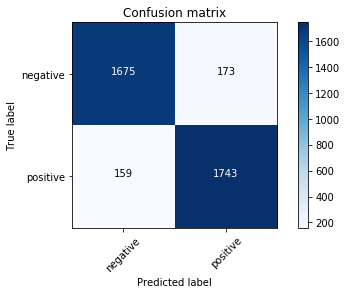

In [114]:
plot_confusion_matrix(cm, ['negative', 'positive'])

In [116]:
pred = conv.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_cnn.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_cnn.csv">here</a>.</p>')

============================================================

In [300]:
conv = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, dropout=0.2),
    Dropout(0.2),
    Convolution1D(64, 5, border_mode='same', activation='relu'),
    MaxPooling1D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.75),
    Dense(1, activation='sigmoid')])
conv.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [301]:
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=1, batch_size=64)

Train on 22500 samples, validate on 2500 samples
Epoch 1/1
22500/22500 [==============================] - 5s - loss: 0.4733 - acc: 0.7478 - val_loss: 0.2464 - val_acc: 0.9028


In [322]:
from sklearn.metrics import roc_auc_score
pred_val = conv.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96392284913965576

In [285]:
pred = conv.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_cnn.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_cnn.csv">here</a>.</p>')

### Multi-size CNNs

In [35]:
def build_cnn(embedding_dim):
    inp = Input(shape=(seq_len,), dtype='int32', name='model_input')
    emb = Embedding(vocab_size, embedding_dim, input_length=seq_len, dropout=0.2)(inp)
    x = Dropout(0.2)(emb)
    
    branch3 = Convolution1D(48, 3, border_mode='same', activation='relu')(x)
    branch5 = Convolution1D(48, 5, border_mode='same', activation='relu')(x)
    branch7 = Convolution1D(48, 7, border_mode='same', activation='relu')(x)
    x = merge([branch3, branch5, branch7], mode='concat', concat_axis=1)
    
    x = MaxPooling1D(pool_length=4)(x)
    x = Flatten()(x)
    
    x = Dense(96, activation='relu')(x)
    x = Dropout(0.75)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inp, x)
    model.compile(Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [417]:
conv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
model_input (InputLayer)         (None, 500)           0                                            
____________________________________________________________________________________________________
embedding_99 (Embedding)         (None, 500, 64)       3200000     model_input[0][0]                
____________________________________________________________________________________________________
dropout_194 (Dropout)            (None, 500, 64)       0           embedding_99[0][0]               
____________________________________________________________________________________________________
convolution1d_156 (Convolution1D (None, 500, 48)       9264        dropout_194[0][0]                
___________________________________________________________________________________________

In [75]:
conv = build_cnn(48)
#metricRecords = CallMetric()
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_cnn_ms.h5", monitor='val_acc', 
#                                   save_best_only=True, verbose=1)

In [338]:
conv.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=64)

Train on 22500 samples, validate on 2500 samples
Epoch 1/2
22500/22500 [==============================] - 14s - loss: 0.4926 - acc: 0.7299 - val_loss: 0.2594 - val_acc: 0.9036
Epoch 2/2
22500/22500 [==============================] - 14s - loss: 0.2497 - acc: 0.9076 - val_loss: 0.2340 - val_acc: 0.9116


In [431]:
pred_val = conv.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96963905562224895

In [44]:
pred = conv.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_cnn.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_cnn.csv">here</a>.</p>')

In [57]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, [1.0 if p>0.5 else 0.0 for p in pred_val])

In [58]:
np.mean(np.array(val_y) == np.ones(3750)), np.mean(np.array(val_y) == np.zeros(3750))

(0.49093333333333333, 0.50906666666666667)

In [59]:
# confusion matrix
cm / np.sum(cm, dtype=np.float32)

array([[ 0.4453,  0.0637],
       [ 0.0272,  0.4637]])

[[1670  239]
 [ 102 1739]]


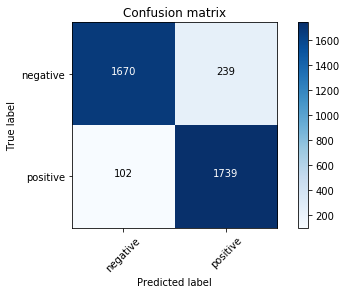

In [60]:
plot_confusion_matrix(cm, ['negative', 'positive'])

### Vanilla RNN

In [57]:
rnn = Sequential([
    Embedding(vocab_size, 64, input_length=seq_len, mask_zero=True),
    SimpleRNN(64, activation='relu', inner_init='identity', return_sequences=True),
    Dropout(0.5),
    SimpleRNN(64, activation='relu', inner_init='identity'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')])
rnn.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
#rnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#metricRecords = CallMetric()
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_rnn.h5", monitor='val_acc', 
#                                   save_best_only=True, verbose=1)

In [58]:
rnn.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=64)

Train on 21250 samples, validate on 3750 samples
Epoch 1/3
21250/21250 [==============================] - 61s - loss: 4.9449 - acc: 0.5242 - val_loss: 0.6614 - val_acc: 0.5256
Epoch 2/3
21250/21250 [==============================] - 61s - loss: 0.6836 - acc: 0.7383 - val_loss: 0.4088 - val_acc: 0.8253
Epoch 3/3
21250/21250 [==============================] - 61s - loss: 0.6118 - acc: 0.8366 - val_loss: 0.3928 - val_acc: 0.8776


In [60]:
from sklearn.metrics import roc_auc_score
rnn.load_weights(model_path+"imdb_rnn.h5")
pred_val = rnn.predict(val_x, batch_size=128)
np.mean((pred_val.ravel()>=0.5).astype('int8') == val_y), roc_auc_score(val_y, pred_val)

(0.88853333333333329, 0.95046789406260235)

### Gated recurrent unit

In [22]:
gru = Sequential([
    Embedding(vocab_size+1, 32, input_length=seq_len, mask_zero=True),
    GRU(64),
    Dropout(0.25),
    Dense(1, activation='sigmoid')])
gru.compile(optimizer=RMSprop(), loss='binary_crossentropy', metrics=['accuracy'])
#metricRecords = CallMetric()
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_gru.h5", monitor='val_acc', 
#                                   save_best_only=True, verbose=1)

In [23]:
gru.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=3, batch_size=128)

Train on 21250 samples, validate on 3750 samples
Epoch 1/3
21250/21250 [==============================] - 58s - loss: 0.5124 - acc: 0.7424 - val_loss: 0.6286 - val_acc: 0.7869
Epoch 2/3
21250/21250 [==============================] - 58s - loss: 0.3097 - acc: 0.8784 - val_loss: 0.3370 - val_acc: 0.8701
Epoch 3/3
21250/21250 [==============================] - 58s - loss: 0.2503 - acc: 0.9056 - val_loss: 0.2631 - val_acc: 0.8987


In [24]:
from sklearn.metrics import roc_auc_score
pred_val = gru.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96131151533359738

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_y, [1.0 if p>0.5 else 0.0 for p in pred_val])

In [32]:
np.mean(np.array(val_y) == np.ones(3750)), np.mean(np.array(val_y) == np.zeros(3750))

(0.50719999999999998, 0.49280000000000002)

In [29]:
# confusion matrix
cm / np.sum(cm, dtype=np.float32)

array([[ 0.4219,  0.0709],
       [ 0.0304,  0.4768]])

[[1582  266]
 [ 114 1788]]


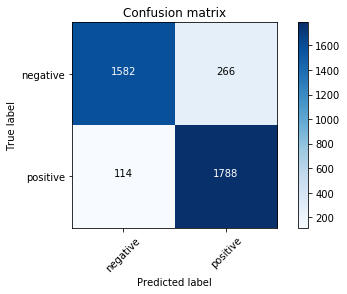

In [33]:
plot_confusion_matrix(cm, ['negative', 'positive'])

In [27]:
pred = gru.predict(test_x, batch_size=128)
submit = pd.DataFrame({ 'id': test['id'], 'sentiment': pred[:,0] })
submit.to_csv('imdb_gru.csv', index=False)
from IPython.display import HTML
HTML('<p>The submission is <a href="imdb_gru.csv">here</a>.</p>')

### Bi-directional recurrent net

In [15]:
bi_gru = Sequential([
    Embedding(vocab_size, 32, input_length=seq_len, mask_zero=True),
    Bidirectional(GRU(64)),
    Dropout(0.25),
    Dense(1, activation='sigmoid')])
bi_gru.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
#metricRecords = CallMetric()
#checkpointer = kcb.ModelCheckpoint(filepath=model_path+"imdb_gru_bidir.h5", monitor='val_acc', 
#                                   save_best_only=True, verbose=1)

In [17]:
bi_gru.fit(train_x, train_y, validation_data=(val_x, val_y), nb_epoch=2, batch_size=128)

Train on 21250 samples, validate on 3750 samples
Epoch 1/2
21250/21250 [==============================] - 115s - loss: 0.5693 - acc: 0.6873 - val_loss: 0.3075 - val_acc: 0.8827
Epoch 2/2
21250/21250 [==============================] - 115s - loss: 0.2691 - acc: 0.8930 - val_loss: 0.2669 - val_acc: 0.8915


In [18]:
from sklearn.metrics import roc_auc_score
pred_val = bi_gru.predict(val_x, batch_size=128)
roc_auc_score(val_y, pred_val)

0.96043837427906831